# 01 – Preprocesamiento y Normalización de Landmarks

Este notebook prepara el conjunto de datos para entrenamiento del modelo de reconocimiento de actividad humana (HAR).

**Pasos principales:**
1. Cargar datos desde Supabase o CSV.
2. Explotar los frames y filtrar por calidad.
3. Normalizar coordenadas de landmarks.
4. Suavizar ruido temporal.
5. Agregar características (ángulos, velocidades, inclinación del tronco) por ventana.
6. Exportar `features.csv` para los notebooks de modelado.

## Dependencias y entorno

In [25]:
%pip install -r ../requirements.txt

import os
import pandas as pd
from dotenv import load_dotenv
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from Entrega2.src.utils.data_utils import load_from_supabase, explode_frames_table
from Entrega2.src.features.feature_engineering import prepare_video_windows

load_dotenv()

# Variables clave
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "../experiments/results")
OUTPUT_CSV = os.getenv("OUTPUT_CSV", "features.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Cargar datos desde supabase

In [26]:
print("🔌 Cargando datos desde Supabase...")
df = load_from_supabase()

print("✅ Registros cargados:")
print(df.head(3))
print(f"Total videos: {len(df)}")

🔌 Cargando datos desde Supabase...
✅ Registros cargados:
   id_lm                              video_id  \
0     41  8e26196e-4e06-40fe-9ca2-809f0858685c   
1     42  1d00f9dc-1af5-49d0-9210-f56186842ec9   
2     43  5276d09c-8ec6-4aec-83b4-078748e0e64a   

                                           landmarks  \
0  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
1  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
2  {'fps': 30.00968054211036, 'frames': [{'landma...   

                   created_at  \
0  2025-10-12T00:26:32.197995   
1  2025-10-12T00:26:39.463527   
2  2025-10-12T00:26:47.353804   

                                      landmarks_json  \
0  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
1  {'fps': 30.0, 'frames': [{'landmarks': {'head'...   
2  {'fps': 30.00968054211036, 'frames': [{'landma...   

                                   id_v      filename        fps resolution  \
0  8e26196e-4e06-40fe-9ca2-809f0858685c  IMG_0627.MOV  30.000000  3840x2160   
1

## Exportar frames (convertir JSON a tabla)

In [27]:
frames_df = explode_frames_table(df)
print(f"Frames totales: {len(frames_df):,}")
frames_df.head(2)

Frames totales: 6,083


,video_id,label,fps,frame_index,timestamp,landmarks,width,height,duration_sec,lighting,resolution
0,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse,30.0,16,0.533333,"{'head': {'x': 0.2035171315073967, 'y': 0.9397...",3840,2160,5.233333,129.94568,3840x2160
1,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse,30.0,21,0.700000,"{'head': {'x': 0.21029268205165863, 'y': 0.890...",3840,2160,5.233333,129.94568,3840x2160


## Preprocesamiento y generación de features

In [28]:
from dotenv import load_dotenv
import numpy as np

load_dotenv()

# Parámetros del entorno
visibility_min = float(os.getenv("VISIBILITY_MIN", 0.8))
min_frames = int(os.getenv("MIN_FRAMES_PER_VIDEO", 10))
win_sec = float(os.getenv("WINDOW_SIZE_SEC", 1.0))
step_sec = float(os.getenv("WINDOW_STEP_SEC", 0.5))
smooth_win = int(os.getenv("SMOOTH_WINDOW", 5))

print("⚙️ Parámetros actuales:")
print(f"VISIBILITY_MIN={visibility_min}, MIN_FRAMES_PER_VIDEO={min_frames}")
print(f"WINDOW_SIZE_SEC={win_sec}, STEP_SEC={step_sec}, SMOOTH_WINDOW={smooth_win}")

features_df = prepare_video_windows(
    frames_df,
    visibility_min=visibility_min,
    min_frames_per_video=min_frames,
    win_sec=win_sec,
    step_sec=step_sec,
    smooth_window=smooth_win,
)

print("✅ Features generadas:", features_df.shape)
features_df.head(5)


⚙️ Parámetros actuales:
VISIBILITY_MIN=0.8, MIN_FRAMES_PER_VIDEO=10
WINDOW_SIZE_SEC=1.0, STEP_SEC=0.5, SMOOTH_WINDOW=5


c:\Users\manue\OneDrive\Escritorio\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:420: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\manue\OneDrive\Escritorio\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:424: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_df = pd.DataFrame(depth_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\manue\OneDrive\Escritorio\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:425: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  width_df = pd.DataFrame(width_pe

✅ Features generadas: (175, 54)


c:\Users\manue\OneDrive\Escritorio\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:420: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\manue\OneDrive\Escritorio\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:424: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  depth_df = pd.DataFrame(depth_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\manue\OneDrive\Escritorio\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:425: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  width_df = pd.DataFrame(width_pe

,knee_left_mean,knee_left_std,knee_right_mean,knee_right_std,hip_left_mean,hip_left_std,hip_right_mean,hip_right_std,inclination_mean,inclination_std,...,vel_right_wrist_mean,vel_right_wrist_p90,vel_head_mean,vel_head_p90,angular_velocity_mean,angular_velocity_max,frame_start,frame_end,video_id,label
0,2.809319,0.238960,1.963360,0.439324,2.854180,0.144649,2.096193,0.411019,1.448148,0.157631,...,2.092434,4.737202,2.560572,4.723698,0.272698,0.780254,76,156,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse
1,2.722190,0.281661,2.464425,0.362735,2.669825,0.259454,2.423046,0.261321,1.627710,0.033428,...,1.540819,3.694985,2.326005,6.070343,0.203038,0.600302,0,105,011d6524-bb00-49fc-80d5-9e97161ac9ff,ponerse_de_pie
2,3.018146,0.168501,2.892542,0.233494,2.873198,0.132569,3.017637,0.107162,0.048602,0.035068,...,0.809599,2.051498,1.134735,2.532875,26.247450,156.617574,10,130,026c2c6b-d509-4f2d-9535-5cc10e2d5042,caminar
3,3.053953,0.079269,3.004244,0.126800,2.849931,0.127685,2.787469,0.091497,0.119382,0.069325,...,0.616362,1.461023,1.551165,2.797191,13.128029,187.487127,0,145,0358999b-7d10-4fa6-8e90-b55207cbe0ff,sentarse
4,2.981027,0.092635,2.751744,0.161392,3.007329,0.085631,3.002173,0.094994,0.052748,0.035720,...,1.417325,3.695630,2.476126,6.439963,22.627732,156.432280,0,70,058a2a00-c790-4f3c-936a-d3c460e092e5,caminar


In [29]:
# Cuántos videos válidos quedaron por label después del filtrado
frames_df.groupby("label")["video_id"].nunique()



label
caminar           97
girar             69
ponerse_de_pie    64
sentarse          63
Name: video_id, dtype: int64

In [30]:
# Cuántas ventanas finales hay por label
features_df["label"].value_counts()


label
caminar           70
sentarse          38
ponerse_de_pie    38
girar             29
Name: count, dtype: int64

## Guardar resultados

In [32]:
out_path = os.path.join(OUTPUT_DIR, OUTPUT_CSV)
features_df.to_csv(out_path, index=False)
print(f"📁 Archivo guardado en: {out_path}")

print("Clases y conteos:")
print(features_df["label"].value_counts())

📁 Archivo guardado en: Entrega2/experiments/results\features.csv
Clases y conteos:
label
caminar           70
sentarse          38
ponerse_de_pie    38
girar             29
Name: count, dtype: int64


## Visualización rápida

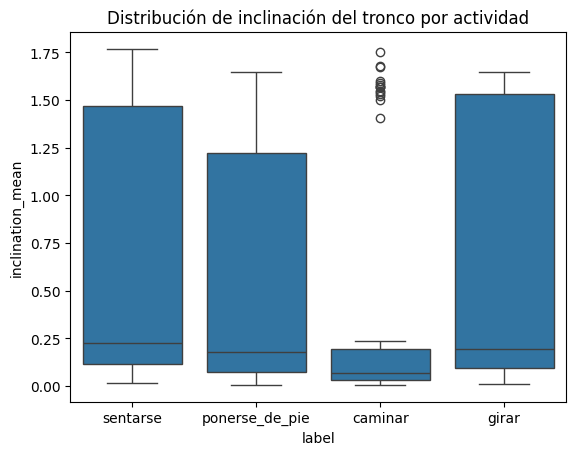

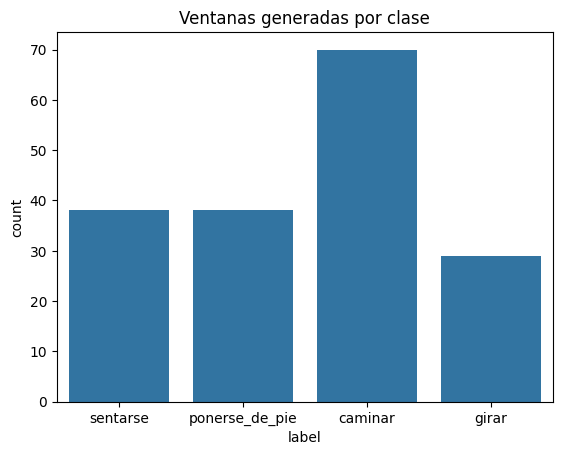

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de inclinación promedio por clase
sns.boxplot(x="label", y="inclination_mean", data=features_df)
plt.title("Distribución de inclinación del tronco por actividad")
plt.show()

# Conteo de ventanas por clase
sns.countplot(x="label", data=features_df)
plt.title("Ventanas generadas por clase")
plt.show()


## Conclusiones del preprocesamiento

- Se cargaron los datos desde Supabase y se procesaron correctamente.
- Los filtros de visibilidad eliminaron videos con baja calidad.
- Las coordenadas se normalizaron con referencia pélvica y escala de hombros.
- Las features agregadas (ángulos, velocidades, inclinación) se calcularon por ventana temporal.
- Se exportó un dataset balanceado por clases (`features.csv`) para el entrenamiento.


# Actualización del pipeline de preprocesamiento

Este notebook usa los últimos cambios del pipeline:
- Filtro mínimo de frames por etiqueta (percentil 10 por clase con mínimo absoluto)
- Ventanas temporales con features nuevas basadas en timestamps: t_start, t_end, t_duration, video_progress
- Tendencias por landmark (trend_*_vx, trend_*_vy) y desplazamiento neto por landmark (disp_*_dx, disp_*_dy, disp_*_mag)

Puedes cargar datos desde Supabase (usando .env) o desde CSVs y exportar `features.csv` listo para modelado.

In [10]:
# Configurar y ejecutar el pipeline actualizado
import os
import pandas as pd
from Entrega2.src.utils.data_utils import load_from_supabase, load_from_csv, explode_frames_table
from Entrega2.src.features.feature_engineering import prepare_video_windows, DEFAULT_VISIBILITY_MIN, DEFAULT_MIN_FRAMES_PER_VIDEO, DEFAULT_WINDOW_SIZE_SEC, DEFAULT_WINDOW_STEP_SEC

# Parámetros (puedes ajustar)
VISIBILITY_MIN = float(os.getenv('VISIBILITY_MIN', DEFAULT_VISIBILITY_MIN))
MIN_FRAMES_PER_VIDEO = int(os.getenv('MIN_FRAMES_PER_VIDEO', DEFAULT_MIN_FRAMES_PER_VIDEO))
WINDOW_SIZE_SEC = float(os.getenv('WINDOW_SIZE_SEC', DEFAULT_WINDOW_SIZE_SEC))
WINDOW_STEP_SEC = float(os.getenv('WINDOW_STEP_SEC', DEFAULT_WINDOW_STEP_SEC))
OUTPUT_DIR = os.getenv('OUTPUT_DIR', 'Entrega2/experiments/results')
OUTPUT_CSV = os.getenv('OUTPUT_CSV', 'features.csv')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fuente de datos: elige una opción
USE_SUPABASE = os.getenv('USE_SUPABASE', '1') == '1'
VIDEOS_CSV = os.getenv('VIDEOS_CSV', None)
LANDMARKS_CSV = os.getenv('LANDMARKS_CSV', None)

if USE_SUPABASE:
    print('🔌 Cargando desde Supabase…')
    df = load_from_supabase()
else:
    print('📄 Cargando desde CSVs…')
    if not VIDEOS_CSV or not LANDMARKS_CSV:
        raise SystemExit('Define VIDEOS_CSV y LANDMARKS_CSV en variables de entorno o usa Supabase.')
    df = load_from_csv(VIDEOS_CSV, LANDMARKS_CSV)

assert not df.empty, 'No se obtuvieron registros'

# Explode de frames
frames_df = explode_frames_table(df)
print('Frames totales:', len(frames_df))

# Filtro mínimo de frames por etiqueta (percentil 10 por clase, con mínimo absoluto)
try:
    counts = frames_df.groupby(['video_id', 'label'], dropna=False)['frame_index'].count().reset_index(name='n_frames')
    per_label_p10 = counts.groupby('label')['n_frames'].quantile(0.10).to_dict()
    thresholds = {lbl: max(int(p10), int(MIN_FRAMES_PER_VIDEO)) for lbl, p10 in per_label_p10.items()}
    counts['threshold'] = counts['label'].map(thresholds)
    keep_vids = counts[counts['n_frames'] >= counts['threshold']]['video_id'].unique().tolist()
    frames_df = frames_df[frames_df['video_id'].isin(keep_vids)].reset_index(drop=True)
    print('Videos tras filtro por etiqueta:', frames_df['video_id'].nunique())
except Exception as e:
    print('⚠️ No se pudo aplicar filtro por etiqueta:', e)

# Preparación de ventanas y features
feat_df = prepare_video_windows(
    frames_df,
    visibility_min=VISIBILITY_MIN,
    min_frames_per_video=MIN_FRAMES_PER_VIDEO,
    win_sec=WINDOW_SIZE_SEC,
    step_sec=WINDOW_STEP_SEC,
    smooth_window=5,
 )

print('Features shape:', feat_df.shape)
cols_preview = [c for c in feat_df.columns if c in ['t_start','t_end','t_duration','video_progress','frame_start','frame_end']][:10]
cols_preview += [c for c in feat_df.columns if c.startswith('trend_')][:4]
cols_preview += [c for c in feat_df.columns if c.startswith('disp_')][:4]
display(feat_df[ ['video_id','label'] + cols_preview ].head(8))

# Guardar a CSV
out_path = os.path.join(OUTPUT_DIR, OUTPUT_CSV)
feat_df.to_csv(out_path, index=False)
print('✅ Features exportadas a:', out_path)

🔌 Cargando desde Supabase…
Frames totales: 5120
Videos tras filtro por etiqueta: 198
Frames totales: 5120
Videos tras filtro por etiqueta: 198


c:\Users\Juan Camilo\OneDrive\Escritorio\Universidad\Septimo Semestre\Inteligencia Artificial\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:394: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\Juan Camilo\OneDrive\Escritorio\Universidad\Septimo Semestre\Inteligencia Artificial\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:394: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\Juan Camilo\OneDrive\Escritorio\Universidad\Septimo Semestre\Inteligencia Artificial\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py

Features shape: (139, 106)


c:\Users\Juan Camilo\OneDrive\Escritorio\Universidad\Septimo Semestre\Inteligencia Artificial\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:394: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\Juan Camilo\OneDrive\Escritorio\Universidad\Septimo Semestre\Inteligencia Artificial\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py:394: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ang_df = pd.DataFrame(angles_per_frame).fillna(method="ffill").fillna(method="bfill")
c:\Users\Juan Camilo\OneDrive\Escritorio\Universidad\Septimo Semestre\Inteligencia Artificial\IA1_VideoActivityRecognition_ICESI_2025_2\Entrega2\src\features\feature_engineering.py

,video_id,label,t_start,t_end,t_duration,video_progress,frame_start,frame_end,trend_left_hip_vx,trend_left_hip_vy,trend_right_hip_vx,trend_right_hip_vy,disp_left_hip_dx,disp_left_hip_dy,disp_left_hip_mag,disp_right_hip_dx
0,006beb60-8b9e-4b79-867a-ca1c2f386ce2,sentarse,2.533333,5.200000,2.666667,0.500000,76,156,0.008679,-0.004159,-0.008679,0.004159,0.028533,-0.018746,0.034140,-0.028533
1,011d6524-bb00-49fc-80d5-9e97161ac9ff,ponerse_de_pie,0.000000,3.500000,3.500000,0.500000,0,105,0.000433,0.012368,-0.000433,-0.012368,-0.003098,0.041805,0.041920,0.003098
2,026c2c6b-d509-4f2d-9535-5cc10e2d5042,caminar,0.400266,5.203459,4.803193,0.444444,10,130,-0.007475,0.001372,0.007475,-0.001372,-0.065336,0.012168,0.066459,0.065336
3,0358999b-7d10-4fa6-8e90-b55207cbe0ff,sentarse,0.000000,4.846527,4.846527,0.439394,0,145,-0.006838,0.001178,0.006838,-0.001178,-0.020719,0.009897,0.022962,0.020719
4,05d7f585-9811-4f61-a418-c690f0bada10,caminar,0.000000,4.803386,4.803386,0.480000,0,120,0.007471,-0.003193,-0.007471,0.003193,0.025824,-0.009837,0.027634,-0.025824
5,06054c67-d2eb-4c71-8f94-4769632416ab,ponerse_de_pie,0.000000,4.847069,4.847069,0.414286,0,145,-0.007713,0.002969,0.007713,-0.002969,-0.026207,0.018518,0.032089,0.026207
6,0c77d548-3254-42d6-a218-57fa231d7c3a,caminar,1.733333,4.233333,2.500000,0.500000,52,127,0.013822,0.248375,-0.013822,-0.248375,0.060614,0.203830,0.212652,-0.060614
7,0d623b5b-79b2-49c0-8349-4b5c2128bf01,ponerse_de_pie,0.000000,3.641333,3.641333,0.500000,0,90,-0.038554,0.016722,0.038554,-0.016722,-0.015544,0.058282,0.060319,0.015544


✅ Features exportadas a: ../experiments/results\features.csv
